In [82]:
import os
import errno

import numpy as np
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K

from deepcell import get_data
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell.model_zoo import bn_feature_net_2D
from deepcell.model_zoo import bn_feature_net_61x61
from deepcell.model_zoo import bn_feature_net_skip_2D
from deepcell.training import train_model_conv
from deepcell.training import train_model_sample

In [83]:
RESIZE = False
RESHAPE_SIZE = 128
NUM_FRAMES = 15  # get first N frames from each training folder

WIN_X = 30
WIN_Y = 30
WIN_Z = 2

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
DATA_FILE = 'nuclear_general'

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 2 if IS_CHANNELS_FIRST else 1
COL_AXIS = 3 if IS_CHANNELS_FIRST else 2
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 3

def make_dirs(prefix):
    # create these directories if they do not exist
    for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
        try:
            os.makedirs(os.path.join(d, prefix))
            print('Created new directory:', os.path.join(d, prefix))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise

## Load Each Dataset

In [3]:
mousebrain_prefix = 'cells/MouseBrain/generic'
mousebrain_datafile = 'MouseBrain'

make_dirs(mousebrain_prefix)

# Create the training data
make_training_data(
    dimensionality=3,
    direc_name=os.path.join(DATA_DIR, mousebrain_prefix),
    file_name_save=os.path.join(NPZ_DIR, mousebrain_prefix, mousebrain_datafile),
    channel_names=[''],  # for iterating over stacks of images from a montage
    training_direcs=None,  # all training directories
    reshape_size=None if not RESIZE else RESHAPE_SIZE,
    num_frames=15,
    montage_mode=True,  # annotation folder has montaged sub-dirs
    annotation_name='',  # basically channel name but for annotated images
    raw_image_direc='stacked_raw_parts',
    annotation_direc='annotated/all_montages')

if os.path.isfile(os.path.join(NPZ_DIR, mousebrain_prefix, mousebrain_datafile) + '.npz'):
    print('\nData saved to', os.path.join(NPZ_DIR, mousebrain_prefix, mousebrain_datafile) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')

Reshaped feature data from (220, 15, 256, 256, 1) to (880, 15, 128, 128, 1)
Reshaped training data from (220, 15, 256, 256, 1) to (880, 15, 128, 128, 1)

Data saved to /data/npz_data/cells/MouseBrain/generic/MouseBrain.npz


In [70]:
hek_prefix = 'cells/HEK293/generic'
hek_datafile = 'HEK293_generic'

hek_movie_dirs = [os.path.join('set{}'.format(i), 'part_1', 'movie') for i in range(3)]
hek_movie_dirs.extend([os.path.join('set{}'.format(i), 'part_2', 'movie') for i in range(3)])

hek_train_dirs = []
for movie_dir in hek_movie_dirs:
    full_movie_dir = os.path.join(DATA_DIR, hek_prefix, movie_dir)
    for subdir in os.listdir(full_movie_dir):
        hek_train_dirs.append(os.path.join(movie_dir, subdir))

make_dirs(hek_prefix)

# Create the training data
make_training_data(
    dimensionality=3,
    direc_name=os.path.join(DATA_DIR, hek_prefix),
    file_name_save=os.path.join(NPZ_DIR, hek_prefix, hek_datafile),
    channel_names=[''],  # for iterating over stacks of images from a montage
    training_direcs=hek_train_dirs,  # all training directories
    reshape_size=None if not RESIZE else RESHAPE_SIZE,
    num_frames=30,
    montage_mode=False,  # annotation folder has montaged sub-dirs
    annotation_name='',  # basically channel name but for annotated images
    raw_image_direc='raw',
    annotation_direc='annotated')

if os.path.isfile(os.path.join(NPZ_DIR, hek_prefix, hek_datafile) + '.npz'):
    print('\nData saved to', os.path.join(NPZ_DIR, hek_prefix, hek_datafile) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')


Data saved to /data/npz_data/cells/HEK293/generic/HEK293_generic.npz


In [71]:
hela_prefix = 'cells/HeLa/S3'
hela_datafile = 'HeLa_S3'

hela_movie_dirs = [os.path.join('set{}'.format(i), 'movie') for i in range(8)]
hela_train_dirs = []
for movie_dir in hela_movie_dirs:
    full_movie_dir = os.path.join(DATA_DIR, hela_prefix, movie_dir)
    for subdir in os.listdir(full_movie_dir):
        hela_train_dirs.append(os.path.join(movie_dir, subdir))

make_dirs(hela_prefix)

# Create the training data
make_training_data(
    dimensionality=3,
    direc_name=os.path.join(DATA_DIR, hela_prefix),
    file_name_save=os.path.join(NPZ_DIR, hela_prefix, hela_datafile),
    channel_names=[''],  # for iterating over stacks of images from a montage
    training_direcs=hela_train_dirs,  # all training directories
    reshape_size=None if not RESIZE else RESHAPE_SIZE,
    num_frames=40,
    montage_mode=False,  # annotation folder has montaged sub-dirs
    annotation_name='',  # basically channel name but for annotated images
    raw_image_direc='raw',
    annotation_direc='annotated')

if os.path.isfile(os.path.join(NPZ_DIR, hela_prefix, hela_datafile) + '.npz'):
    print('\nData saved to', os.path.join(NPZ_DIR, hela_prefix, hela_datafile) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')


Data saved to /data/npz_data/cells/HeLa/S3/HeLa_S3.npz


In [72]:
nih_prefix = 'cells/3T3/NIH'
nih_datafile = '3T3_NIH'

nih_movie_dirs = [os.path.join('set{}'.format(i), 'part_1', 'movie') for i in range(3)]
nih_movie_dirs.extend([os.path.join('set{}'.format(i), 'part_2', 'movie') for i in range(3)])

nih_train_dirs = []
for movie_dir in nih_movie_dirs:
    full_movie_dir = os.path.join(DATA_DIR, nih_prefix, movie_dir)
    for subdir in os.listdir(full_movie_dir):
        nih_train_dirs.append(os.path.join(movie_dir, subdir))

make_dirs(nih_prefix)

# Create the training data
make_training_data(
    dimensionality=3,
    direc_name=os.path.join(DATA_DIR, nih_prefix),
    file_name_save=os.path.join(NPZ_DIR, nih_prefix, nih_datafile),
    channel_names=[''],  # for iterating over stacks of images from a montage
    training_direcs=nih_train_dirs,  # all training directories
    reshape_size=None if not RESIZE else RESHAPE_SIZE,
    num_frames=30,
    montage_mode=False,  # annotation folder has montaged sub-dirs
    annotation_name='',  # basically channel name but for annotated images
    raw_image_direc='raw',
    annotation_direc='annotated')

if os.path.isfile(os.path.join(NPZ_DIR, nih_prefix, nih_datafile) + '.npz'):
    print('\nData saved to', os.path.join(NPZ_DIR, nih_prefix, nih_datafile) + '.npz')
    ALL_FILES.append(os.path.join(NPZ_DIR, nih_prefix, nih_datafile) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')


Data saved to /data/npz_data/cells/3T3/NIH/3T3_NIH.npz


NameError: name 'ALL_FILES' is not defined

## Flatten All Datasets into 2D and Combine

In [73]:
# mb_train, mb_test = get_data(os.path.join(NPZ_DIR, mousebrain_prefix, mousebrain_datafile) + '.npz')

hela_train, hela_test = get_data(os.path.join(NPZ_DIR, 'cells/HeLa/S3', hela_datafile) + '.npz')

hek_train, hek_test = get_data(os.path.join(NPZ_DIR, 'cells/HEK293/generic', hek_datafile) + '.npz')

nih_train, nih_test = get_data(os.path.join(NPZ_DIR, 'cells/3T3/NIH', nih_datafile) + '.npz')

In [76]:
def count_cells(train, test, name):
    y = np.vstack([train['y'], test['y']])
    y_reshape = np.resize(y, (y.shape[0] * y.shape[1], *y.shape[2:]))
    total_cells = 0
    for i in range(y_reshape.shape[0]):
        unique = np.unique(y_reshape[i])
        total_cells += (len(unique) - 1)
    print('{} Total {} Cells'.format(total_cells, name))

count_cells(nih_train, nih_test, '3T3_NIH')
count_cells(hek_train, hek_test, 'HEK293')
count_cells(hela_train, hela_test, 'HeLa_S3')

82066 Total 3T3_NIH Cells
193840 Total HEK293 Cells
55190 Total HeLa_S3 Cells


In [75]:
nih_train['y'].shape

(259, 30, 154, 182, 1)

In [ ]:
def reshape_data(data):
    return np.resize(data, (data.shape[0] * data.shape[1], *data.shape[2:]))

# X_mb_train, y_mp_train = reshape_data(mb_train['X']), reshape_data(mb_train['y'])
X_hela_train, y_hela_train = reshape_data(hela_train['X']), reshape_data(hela_train['y'])
X_hek_train, y_hek_train = reshape_data(hek_train['X']), reshape_data(hek_train['y'])
X_nih_train, y_nih_train = reshape_data(nih_train['X']), reshape_data(nih_train['y'])

# X_mb_test, y_mp_test = reshape_data(mb_test['X']), reshape_data(mb_test['y'])
X_hela_test, y_hela_test = reshape_data(hela_test['X']), reshape_data(hela_test['y'])
X_hek_test, y_hek_test = reshape_data(hek_test['X']), reshape_data(hek_test['y'])
X_nih_test, y_nih_test = reshape_data(nih_test['X']), reshape_data(nih_test['y'])

In [ ]:
X_train = np.vstack([X_hela_train, X_hek_train, X_nih_train])
y_train = np.vstack([y_hela_train, y_hek_train, y_nih_train])

X_test = np.vstack([X_hela_test, X_hek_test, X_nih_test])
y_test = np.vstack([y_hela_test, y_hek_test, y_nih_test])

X = np.vstack([X_train, X_test])
y = np.vstack([y_train, y_test])

In [49]:
np.savez(os.path.join(NPZ_DIR, DATA_FILE) + '.npz', X=X, y=y)

## Train a General Nuclear Model

In [84]:
train_dict, test_dict = get_data(os.path.join(NPZ_DIR, DATA_FILE) + '.npz')

X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_trest = test_dict['X'], test_dict['y']

In [85]:
# Set up training parameters
n_epoch = 4
batch_size = 1
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.95)

# save the size of the input data for batch_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X_train.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    input_shape = (X_train.shape[CHANNEL_AXIS], size[0], size[1])
else:
    input_shape = (size[0], size[1], X_train.shape[CHANNEL_AXIS])

In [86]:
# First, create a foreground/background separation model

# Instantiate the model
fgbg_model = bn_feature_net_skip_2D(
    receptive_field=61,
    n_skips=3,
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=input_shape,
    multires=False,
    last_only=False)
fgbg_model.load_weights('/data/models/2018-09-06_nuclear_general_nuclear_conv_fgbg.h5')

# Train the model
train_model_conv(
    model=fgbg_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    transform=None,  # fg/bg separation
    n_epoch=n_epoch,
    direc_save=MODEL_DIR,
    direc_data=NPZ_DIR,
    expt='nuclear_conv_fgbg',
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (100404, 128, 128, 1)
y_train shape: (100404, 128, 128, 1)
X_test shape: (11156, 128, 128, 1)
y_test shape: (11156, 128, 128, 1)
Output Shape: (None, 128, 128, 2)
Number of Classes: 2
Epoch 1/4
100403/100404 [============================>.] - ETA: 0s - loss: 0.3343 - model_78_loss: 0.0791 - model_79_loss: 0.0778 - model_80_loss: 0.0771 - model_81_loss: 0.0768 - model_78_acc: 0.9119 - model_79_acc: 0.9122 - model_80_acc: 0.9127 - model_81_acc: 0.9129
Epoch 00001: val_loss improved from inf to 0.56293, saving model to /data/models/2018-09-09_nuclear_general_nuclear_conv_fgbg.h5
100404/100404 [==============================] - 11383s 113ms/step - loss: 0.3343 - model_78_loss: 0.0791 - model_79_loss: 0.0778 - model_80_loss: 0.0771 - model_81_loss: 0.0768 - model_78_acc: 0.9119 - model_79_acc: 0.9122 - model_80_acc: 0.9127 - model_81_acc: 0.9129 - val_loss: 0.5629 - val_model_78_loss: 0.1369 - val_model_79_loss: 0.1356 - val_model_80_loss: 0.1351 - val_model_81_loss: 0.1333 -

In [7]:
# Next, Create a model for the watershed energy transform

BINS = 4
EROSION = 0

# Instantiate the model
watershed_model = bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=61,
    n_skips=3,
    n_features=BINS,
    n_conv_filters=32,
    n_dense_filters=128,
    multires=False,
    last_only=False,
    input_shape=input_shape)

# Train the model
train_model_conv(
    model=watershed_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    transform='watershed',
    distance_bins=BINS,
    erosion_width=EROSION,
    direc_save=MODEL_DIR,
    direc_data=NPZ_DIR,
    expt='conv_watershed',
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (100404, 128, 128, 1)
y_train shape: (100404, 128, 128, 1)
X_test shape: (11156, 128, 128, 1)
y_test shape: (11156, 128, 128, 1)
Output Shape: (None, 128, 128, 4)
Number of Classes: 4
Epoch 1/1
100403/100404 [============================>.] - ETA: 0s - loss: 1.3011 - model_6_loss: 0.3125 - model_7_loss: 0.3108 - model_8_loss: 0.3103 - model_9_loss: 0.3099 - model_6_acc: 0.8314 - model_7_acc: 0.8283 - model_8_acc: 0.8300 - model_9_acc: 0.8294
Epoch 00001: val_loss improved from inf to 2.38903, saving model to /data/models/2018-09-06_nuclear_general_conv_watershed.h5
100404/100404 [==============================] - 15213s 152ms/step - loss: 1.3011 - model_6_loss: 0.3125 - model_7_loss: 0.3108 - model_8_loss: 0.3103 - model_9_loss: 0.3099 - model_6_acc: 0.8314 - model_7_acc: 0.8283 - model_8_acc: 0.8300 - model_9_acc: 0.8294 - val_loss: 2.3890 - val_model_6_loss: 0.5688 - val_model_7_loss: 0.5723 - val_model_8_loss: 0.5887 - val_model_9_loss: 0.6004 - val_model_6_acc: 0.851

## Run the Model

In [8]:
test_images = watershed_model.predict(X_test)[-1]
test_images_fgbg = fgbg_model.predict(X_test)[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=CHANNEL_AXIS - 1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=CHANNEL_AXIS)

print('watershed argmax shape:', argmax_images.shape)

watershed transform shape: (11156, 128, 128, 4)
segmentation mask shape: (11156, 128, 128, 2)
watershed argmax shape: (11156, 128, 128, 1)


In [9]:
# threshold the foreground/background
# and remove back ground from watershed transform
threshold = 0.5
if IS_CHANNELS_FIRST:
    fg_thresh = test_images_fgbg[:, 1, :, :] > threshold
else:
    fg_thresh = test_images_fgbg[:, :, :, 1] > threshold

fg_thresh = np.expand_dims(fg_thresh, axis=CHANNEL_AXIS)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [10]:
# Apply watershed method with the distance transform as seed
from scipy import ndimage
from scipy.ndimage.morphology import distance_transform_edt
from skimage.morphology import watershed, opening, closing
from skimage.feature import peak_local_max
from skimage.morphology import erosion, ball

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    if IS_CHANNELS_FIRST:
        image = fg_thresh[i, 0, :, :]
        distance = argmax_images_post_fgbg[i, 0, :, :]
    else:
        image = fg_thresh[i, :, :, 0]
        distance = argmax_images_post_fgbg[i, :, :, 0]

    local_maxi = peak_local_max(
        test_images[i, :, :, -1],
        min_distance=10,
        threshold_abs=0.05,
        indices=False,
        labels=image,
        exclude_border=False)

    markers = ndimage.label(local_maxi)[0]
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=CHANNEL_AXIS)

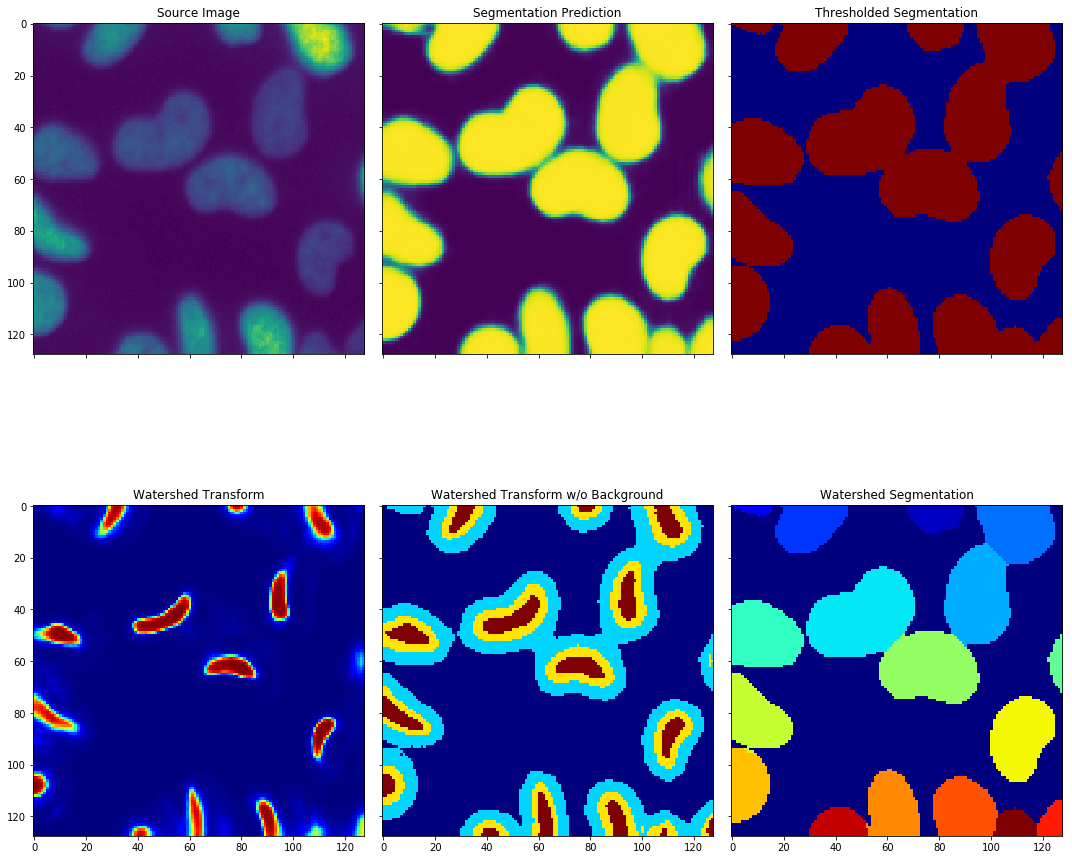

In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

index = 1000

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, :, :, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, :, :, 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, :, :, 0], cmap='jet')
ax[2].set_title('Thresholded Segmentation')

ax[3].imshow(test_images[index, :, :, 3], cmap='jet')
ax[3].set_title('Watershed Transform')

ax[4].imshow(argmax_images_post_fgbg[index, :, :, 0], cmap='jet')
ax[4].set_title('Watershed Transform w/o Background')

ax[5].imshow(watershed_images[index, :, :, 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()

## DeepCell Model

In [15]:
# Next, Create a model for the watershed energy transform

BINS = 4
EROSION = 0

# Instantiate the model
deepcell_model = bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=61,
    n_skips=3,
    n_features=BINS,
    n_conv_filters=32,
    n_dense_filters=128,
    multires=False,
    last_only=False,
    input_shape=input_shape)

# Train the model
train_model_conv(
    model=deepcell_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    transform='deepcell',
    distance_bins=BINS,
    erosion_width=EROSION,
    direc_save=MODEL_DIR,
    direc_data=NPZ_DIR,
    expt='conv_deepcell',
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (100404, 128, 128, 1)
y_train shape: (100404, 128, 128, 1)
X_test shape: (11156, 128, 128, 1)
y_test shape: (11156, 128, 128, 1)
Output Shape: (None, 128, 128, 4)
Number of Classes: 4
Epoch 1/1
100403/100404 [============================>.] - ETA: 0s - loss: 1.4784 - model_18_loss: 0.3572 - model_19_loss: 0.3556 - model_20_loss: 0.3542 - model_21_loss: 0.3539 - model_18_acc: 0.7623 - model_19_acc: 0.7618 - model_20_acc: 0.7623 - model_21_acc: 0.7621
Epoch 00001: val_loss improved from inf to 1.81099, saving model to /data/models/2018-09-07_nuclear_general_conv_deepcell.h5
100404/100404 [==============================] - 15416s 154ms/step - loss: 1.4784 - model_18_loss: 0.3572 - model_19_loss: 0.3556 - model_20_loss: 0.3542 - model_21_loss: 0.3539 - model_18_acc: 0.7623 - model_19_acc: 0.7618 - model_20_acc: 0.7623 - model_21_acc: 0.7621 - val_loss: 1.8110 - val_model_18_loss: 0.4461 - val_model_19_loss: 0.4402 - val_model_20_loss: 0.4335 - val_model_21_loss: 0.4334 - val

In [20]:
test_images_dc = deepcell_model.predict(X_test)[-1]

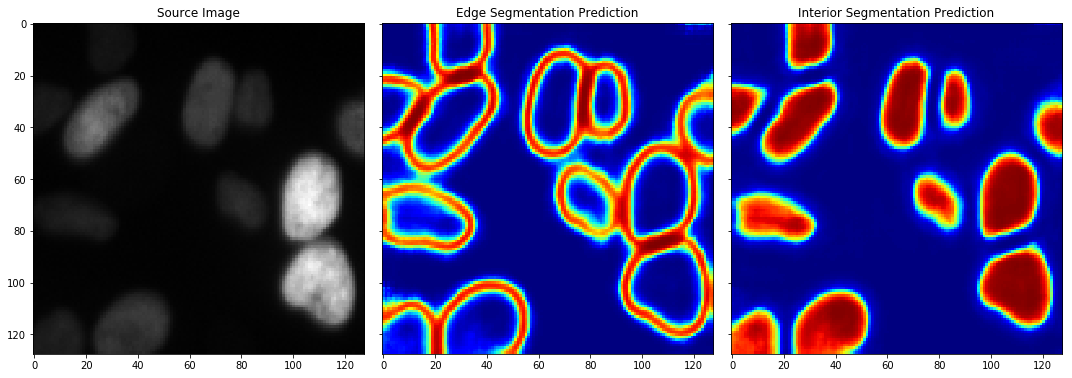

In [26]:
# Plot the results
import matplotlib.pyplot as plt

index = 10000

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, :, :, 0], cmap='gray')
ax[0].set_title('Source Image')

ax[1].imshow(test_images_dc[index, :, :, 0] + test_images_dc[index, :, :, 1], cmap='jet')
ax[1].set_title('Edge Segmentation Prediction')

ax[2].imshow(test_images_dc[index, :, :, 2], cmap='jet')
ax[2].set_title('Interior Segmentation Prediction')

fig.tight_layout()
plt.show()

In [ ]:
import os

import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import signature_def_utils_impl
from tensorflow.python.saved_model.builder import SavedModelBuilder


def export_model(keras_model, export_path, model_version=0, weights_path=None):

    # Start the tensorflow session
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8, allow_growth=False)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

    K.set_session(sess)
    K._LEARNING_PHASE = tf.constant(0)
    K.set_learning_phase(0)

    # Load the model and the weights
    if weights_path is not None:
        keras_model.load_weights(weights_path)

    # Define prediction signature
    prediction_signature = tf.saved_model.signature_def_utils.predict_signature_def(
        {'image': keras_model.input},
        {'prediction': keras_model.output[-1]}
    )

    # Create export path if it doesn't exist
    export_path = os.path.join(export_path, str(model_version))
    builder = SavedModelBuilder(export_path)
    legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')

    # Initialize global variables and the model
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)

    # Add the meta_graph and the variables to the builder
    builder.add_meta_graph_and_variables(
        sess, [tag_constants.SERVING],
        signature_def_map={
            signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
                prediction_signature
        },
        legacy_init_op=legacy_init_op)

    # Save the graph
    builder.save()

In [77]:
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import signature_def_utils_impl
from tensorflow.python.saved_model.builder import SavedModelBuilder


def export_model(keras_model, export_path, model_version=0, weights_path=None):

    # Start the tensorflow session
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8, allow_growth=False)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

    K.set_session(sess)
    K._LEARNING_PHASE = tf.constant(0)
    K.set_learning_phase(0)

    # Load the model and the weights
    if weights_path is not None:
        keras_model.load_weights(weights_path)

    # Define prediction signature
    prediction_signature = tf.saved_model.signature_def_utils.predict_signature_def(
        {'image': keras_model.input},
        {'prediction': keras_model.output[-1]}
    )

    # Create export path if it doesn't exist
    export_path = os.path.join(export_path, str(model_version))
    builder = SavedModelBuilder(export_path)

    # Initialize global variables and the model
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)

    # Add the meta_graph and the variables to the builder
    builder.add_meta_graph_and_variables(
        sess, [tag_constants.SERVING],
        signature_def_map={
            signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
                prediction_signature
        })

    # Save the graph
    builder.save()

In [80]:
model = bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=61,
    n_skips=3,
    n_features=4,
    n_conv_filters=32,
    n_dense_filters=128,
    multires=False,
    last_only=False,
    input_shape=(1280, 1080, 1))

In [81]:
weights_path = '/data/models/2018-09-07_nuclear_general_conv_deepcell.h5'
export_model(model, os.path.join(EXPORT_DIR, 'HeLa_S3_deepcell'), model_version=2, weights_path=weights_path)

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'/data/exports/HeLa_S3_deepcell/1/saved_model.pb'


In [ ]:
weights_path = '/data/models/2018-09-06_nuclear_general_conv_watershed.h5'
export_model(model, os.path.join(EXPORT_DIR, 'HeLa_S3_deepcell'), model_version=2, weights_path=weights_path)